In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
from matplotlib.cm import viridis
from matplotlib.cm import cool
from matplotlib.colors import Normalize
import copy
import random

In [2]:
from ase.io import read
from scipy.interpolate import interp1d, InterpolatedUnivariateSpline
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from pathlib import Path

# Bismuth parameters 
bi_mass = 208.9804
energy_in_ev = 0.004180159285619251 #1 THz = 0.0041 eV
freq_in_thz = 6.3507799295888985 
t_in_ps = 1 / freq_in_thz
x_saddle=0.23589477841686

energies = np.loadtxt("Input_files/toten.dat")
x = np.linspace(-0.5, 0.9, len(energies))
x=x-x_saddle
bi_yinterp = InterpolatedUnivariateSpline(x, np.array(energies) / energy_in_ev, k=5) # energies are converted to THz from eV
neg_bi_yinterp = InterpolatedUnivariateSpline(x, -np.array(energies) / energy_in_ev, k=5) # energies are converted to THz from eV
bi_xmin = minimize(bi_yinterp, [0.0], bounds=[(-0.1-x_saddle, 0.1-x_saddle)]).x
bi_xmin = bi_xmin[0]

bi_xmax = minimize(neg_bi_yinterp, [0.0], bounds=[(-0.1, 0.1)]).x
bi_xmax = bi_xmax[0]

bi_phomega = np.sqrt(bi_yinterp(bi_xmin, nu=2) / bi_mass)
bi_phfreq_in_thz = bi_phomega * freq_in_thz / (2 * np.pi)

print(bi_xmin, bi_phfreq_in_thz)
print("bi_xmax=",bi_xmax)

-0.2368685245784035 3.033783971322573
bi_xmax= -3.0020225651260803e-10


In [3]:
from numpy.linalg import lstsq

# Base directory containing chi_* files
baseDir = "Input_files/chi_files"
# List of all position(x) indices used for interpolation 
all_pos2 = [4, 12, 16, 24, 28, 32, 38, 42, 48, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 68, 73, 80, 88, 96]

# Process CHI data
bi_eps_2eV = [
    row[1] + 1j * row[2]
    for i in all_pos2
    for row in np.loadtxt(f"{baseDir}/chi_{i}.dat", delimiter=" ")
    if 1.90 <= row[0] <= 2.05
]

bi_eps_2eV = np.array(bi_eps_2eV)

# Polynomial Regression Setup
x = x[all_pos2]
y = bi_eps_2eV.real

num = 9
X_poly = np.column_stack([x**i for i in range(0, num, 2)])  # Even powers

# Solve least squares problem
coefficients, _, _, _ = lstsq(X_poly, y, rcond=None)

# Polynomial and its derivative
poly_model = lambda x: sum(c * x**(2 * i) for i, c in enumerate(coefficients))
poly_derivative_func = lambda x: sum((2 * i) * c * x**(2 * i - 1) for i, c in enumerate(coefficients[1:], start=1))


In [4]:
# Network configuration variables
input_size = 1
hidden_size = 5
output_size = 1

#Time array parameters
steps = 20000
total_time=20
tspan = [0, total_time/t_in_ps]
tfine = np.linspace(*tspan, steps)
t_eval = tfine

In [5]:
a=2*np.pi*(1/19.5)/freq_in_thz
b=2*np.pi*(1/0.3)/freq_in_thz

print(a,b)

const_b1 = 1
const_w2 = 10

class TestFNN_ex2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, w1_array):
        super(TestFNN_ex2, self).__init__()
        # Simple feed-forward with one hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, output_size)
        #self.init_weights()
    
    #def init_weights(self):
        self.fc1.weight.data = torch.FloatTensor(w1_array).view(hidden_size, input_size)  # Ensure the correct shape
        nn.init.constant_(self.fc1.bias, const_b1)
        nn.init.constant_(self.fc2.weight, const_w2)
        nn.init.constant_(self.fc2.bias, 0)
    
    def forward(self, x):
        x = torch.sin(self.fc1(x))  # Using sinusoidal activation function
        x = self.fc2(x)
        return x
        
    def get_output(self, time):
        """Get neural network output for a given time input."""
        time_tensor = torch.tensor([[time]], dtype=torch.float32)
        with torch.no_grad():
            return self(time_tensor).item()

            
def mutate(network, mutation_strength=0.2):
    """ Mutates the network by adding Gaussian noise to its weights and biases. """
    with torch.no_grad():
        for name, param in network.named_parameters():
            if name == 'fc1.weight':
                # Generate noise with the same shape as the parameter
                noise = torch.randn_like(param) * mutation_strength
                # Apply noise in-place
                param.add_(noise)
                param.clamp_(min=a, max=b)

0.050736229992191274 3.297854949492433


(-0.5, 15.0)

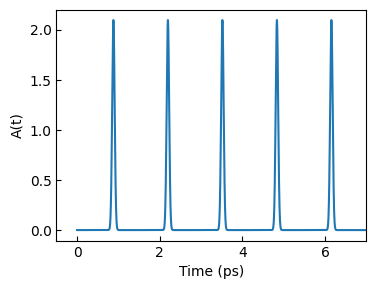

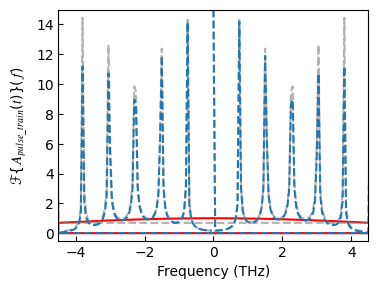

In [7]:
def theor_fft_1(tau):
    
    sigma = (0.03 / t_in_ps)    # Standard deviation of the Gaussian pulses
    total_time = 20/t_in_ps     # Total time window
    
    t = np.linspace(0, total_time, 20000)
    t_sym = np.linspace(-total_time, total_time, 20000)
    num_pulse = 5
    pulse_1 = np.zeros_like(t)
    
    for i in range (0, num_pulse):
        pulse_1 += np.exp(-((t - i*tau - tau/1.5) ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

    pulse_t0 = np.exp(-((t_sym) ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))
    fft_pulse_1 = np.fft.fft(pulse_1-np.mean(pulse_1))
    fft_freq_1 = np.fft.fftfreq(len(t), d=(t[1] - t[0])*t_in_ps)
    
    # consider fft, F(t) = Gaussian term, G_f * Modulation term, M_f
    # Calculate the Gaussian term
    G_f = np.exp(-2 * np.pi**2 * sigma**2 * fft_freq_1**2 * t_in_ps**2) 
    num_pulses = int(total_time // tau)
    phase_shift = np.exp(-1j * 2 * np.pi * fft_freq_1 * tau / 1.5 * t_in_ps)
    geom_sum = np.sum([np.exp(-1j * 2 * np.pi * fft_freq_1 * tau * t_in_ps * n) for n in range(num_pulses)], axis=0)
    M_f = phase_shift * geom_sum
    
    # Combined theoretical FT
    S_f = G_f * M_f
    return pulse_t0, pulse_1, fft_freq_1, G_f, M_f, S_f

t = np.linspace(0, total_time/t_in_ps, 20000)
t_sym = np.linspace(-20/t_in_ps, 20/t_in_ps, 20000)
tau1=2*0.32962/t_in_ps
tau2=4*0.32962/t_in_ps
pulse_t0, pulse2, fft_freq2, G_f2, M_f2, S_f2 = theor_fft_1(tau2)
ifft_gf = np.fft.ifft(G_f2)

alpha=0.5
plt.figure(figsize = (4,3))
plt.plot(t*t_in_ps, pulse2, color='C0')
plt.xlabel('Time (ps)')
plt.ylabel('A(t)')
plt.xlim(-0.5,7)
plt.tick_params(direction='in')

plt.figure(figsize = (4,3))
plt.plot(fft_freq2, G_f2, color='red')
plt.plot(fft_freq2, np.abs(M_f2), color='gray', linestyle='--', alpha=0.6)
plt.plot(fft_freq2, np.abs(S_f2), color='C0', linestyle='--')
plt.xlabel('Frequency (THz)')
plt.ylabel('$ℱ\{𝐴_{𝑝𝑢𝑙𝑠𝑒\_𝑡𝑟𝑎𝑖𝑛} (𝑡)\}(𝑓)$')
plt.tick_params(direction='in')
plt.xlim(-4.5,4.5)
plt.ylim(-0.5,15)


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_pulse(t, center, sigma):
    return np.exp(-((t - center) ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

def sum_gaussian_pulses(t, tau, total_time, sigma):
    total_signal = np.zeros_like(t)
    centers_tau = []
    num_pulses = int(total_time // tau)  # Calculate the number of pulses that fit into the time window
    for n in range(num_pulses):
        # Center each pulse around zero within the time interval starting from 0
        center = n * tau + tau/1.5  
        centers_tau.append(center)
        total_signal += gaussian_pulse(t, center, sigma)

    return total_signal, centers_tau

# Parameters
tau = 5*0.32962/t_in_ps    # Fixed spacing between the centers of Gaussian pulses
sigma = (0.03 / t_in_ps)   # Standard deviation of the Gaussian pulses
total_time = 20/t_in_ps    # Total time window

# Define the time vector outside the function
t = np.linspace(0, total_time, 20000)

signal, centers_tau = sum_gaussian_pulses(t, tau, total_time, sigma)

fft_signal = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(len(signal), d=(t[1] - t[0])*t_in_ps)

# Filter positive frequencies
pos_freqs = fft_freqs > 0
fft_signal_pos = fft_signal[pos_freqs]
fft_freqs_pos = fft_freqs[pos_freqs]

#-------------------------------------------------------------------
# consider fft, F(t) = Gaussian term, G_f * Modulation term, M_f
# Calculate the Gaussian term
G_f = np.exp(-2 * np.pi**2 * sigma**2 * fft_freqs**2 * t_in_ps**2) 

# Modulation term for evenly spaced pulses
num_pulses = int(total_time // tau)
phase_shift = np.exp(-1j * 2 * np.pi * fft_freqs * tau / 1.5 * t_in_ps)
geom_sum = np.sum([np.exp(-1j * 2 * np.pi * fft_freqs * tau * t_in_ps * n) for n in range(num_pulses)], axis=0)
M_f = phase_shift * geom_sum

# Combined theoretical FT
S_f = G_f * M_f
print(len(G_f), len(M_f))

#---------------- IFFT -----------------------
reconst_signal = np.fft.ifft(fft_signal)
reconst_S_f = np.fft.ifft(160*S_f)

# Define the number of columns and calculate the number of rows per column
num_columns = 25
num_rows = len(G_f) // num_columns

# print the data by columns
for row in range(num_rows):
    for col in range(num_columns):
        # Calculate the index in the flat list
        index = col * num_rows + row


20000 20000


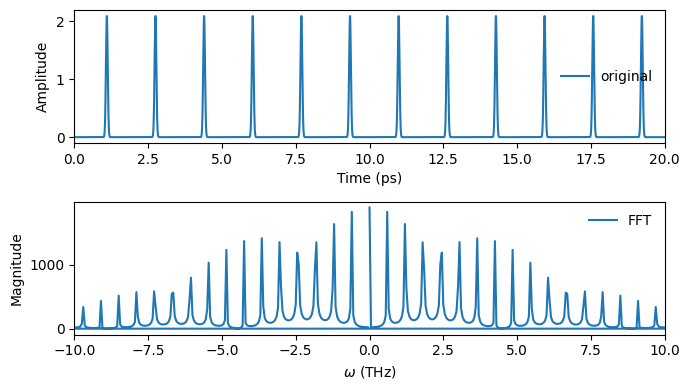

In [9]:
# Plot the time domain signal
plt.figure(figsize=(7, 4))

plt.subplot(2, 1, 1)
plt.plot(t*t_in_ps, signal, label = "original")
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude')
plt.xlim(0,20)
plt.legend(frameon=False)

# Plot the frequency domain signal
plt.subplot(2, 1, 2)
plt.plot(fft_freqs, np.abs(fft_signal), label = 'FFT')
plt.xlabel('$\omega$ (THz)')
plt.ylabel('Magnitude')
plt.xlim(-10,10)
plt.legend(frameon=False)

plt.tight_layout()


In [10]:
def init_pop(size, input_size, hidden_size, output_size, dt=1/bi_phfreq_in_thz):
    population = []
    fc1_wt = []  # List to store the fc1 weights separately
    
    # Generate a list of weights arrays with proper starting value
    for i in range(size):
        increment =   0.20*dt * (i + 1)  # Increment increases with each population
        times_array = np.array([dt + j * increment for j in range(hidden_size)])
        weights_array = 2*np.pi*(1/times_array)/freq_in_thz
        weights_tensor = torch.tensor(weights_array, dtype=torch.float).view(hidden_size, input_size)
        model = TestFNN_ex2(input_size, hidden_size, output_size, weights_array)
        population.append(model)
        fc1_wt.append(weights_tensor)  # Store the numpy array directly

    return population, fc1_wt

n_pop=70
# Initialize population
pop, pop_fc1_wt = init_pop(n_pop, input_size, hidden_size, output_size, dt=1/bi_phfreq_in_thz)

# Simulation time data
time_steps = torch.linspace(*tspan, steps).reshape(-1, 1)  # Simulating over a time span

(0.0, 5.0)

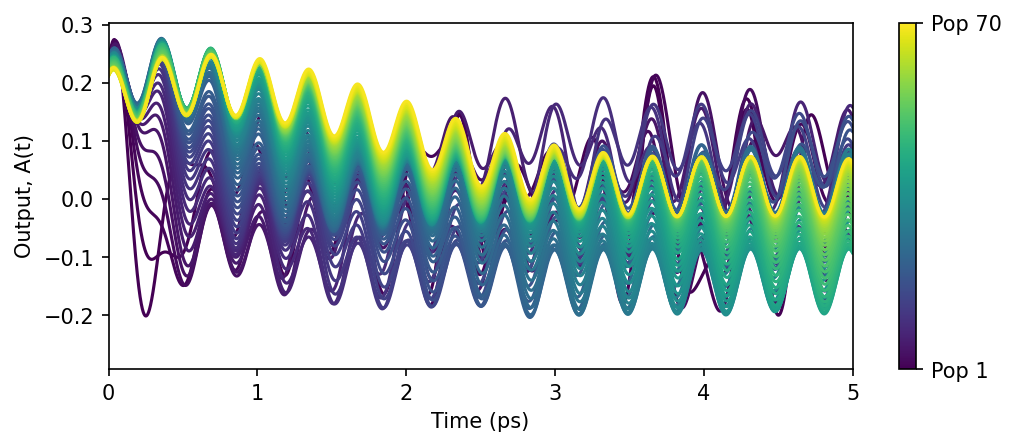

In [11]:
# Plotting the data
from scipy.integrate import simpson

fig, ax = plt.subplots(figsize=(8, 3), dpi=150, facecolor='white')
norm = Normalize(vmin=1, vmax=n_pop)
sm = plt.cm.ScalarMappable(cmap=viridis, norm=norm)
sm.set_array([])

# Plot each network's output 
for i, net in enumerate(pop):
    with torch.no_grad():
        A_t = net(time_steps)
        # Square A(t) to get A(t)^2
        A_t_squared = A_t.squeeze() ** 2 
        A_t_squared_np = A_t_squared.numpy()

        # Perform numerical integration of A(t)^2 over the time domain
        integral_A_t_squared = simpson(y=A_t_squared_np, x=time_steps.numpy().squeeze()) 
        A_t_norm=A_t.numpy()/np.sqrt(integral_A_t_squared)
        
    ax.plot(tfine*t_in_ps, A_t_norm, label=f'Pop {i+1}', color=viridis(norm(i)))
    
# Add colorbar
cbar = plt.colorbar(sm, ax=ax, ticks=range(n_pop))
cbar.set_ticks([norm.vmin, norm.vmax])
cbar.ax.set_yticklabels(['Pop 1', f'Pop {n_pop}']) 

ax.set_xlabel('Time (ps)')
ax.set_ylabel('Output, A(t)')
ax.set_xlim(0,5)


Convert frequency (output from NN) to time domain (for pulsed signals) using IFFT

integral of normalized signal =  1.0


[Text(1, 1.0, 'Pop 1'), Text(1, 70.0, 'Pop 70')]

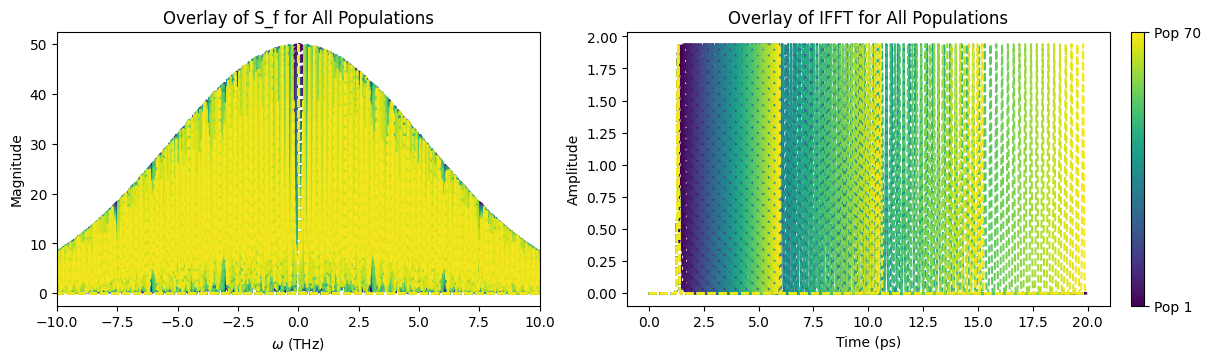

In [12]:
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator

w1 = pop_fc1_wt
b1 = np.full(hidden_size, const_b1)
w2 = np.full(hidden_size, const_w2)

def theor_fft(w1, b1, w2):
    results = []
    for weights in w1:
        weights = np.array(weights, dtype=np.float32)
        M_f_nn = np.sum(
            [w2[n] * np.exp(-1j * 2 * np.pi * fft_freqs * ((2 * np.pi / (freq_in_thz * weights[n])) + b1[n]))
             for n in range(len(weights))], axis=0
        )
        S_f_nn = G_f * M_f_nn
        ifft_nn = np.fft.ifft(S_f_nn)
        results.append((S_f_nn, ifft_nn))
    return results

# Run the function for the population of weights
results = theor_fft(pop_fc1_wt, b1, w2)
t_finer = np.linspace(*tspan, 30000)

cmap = cm.viridis  # Choose a colormap
norm = plt.Normalize(1, n_pop, 256)  

# Create the figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3.5), constrained_layout=True)
colors = [cmap(norm(num)) for num in range(n_pop)]

# Plot for S_f
for idx, (S_f, ifft) in enumerate(results):
    axs[0].plot(fft_freqs, np.abs(S_f), linestyle='--', color=colors[idx])
axs[0].set_title('Overlay of S_f for All Populations')
axs[0].set_xlabel('$\omega$ (THz)')
axs[0].set_ylabel('Magnitude')
axs[0].set_xlim(-10, 10)

# Plot for IFFT
for idx, (S_f, ifft) in enumerate(results[:]):
    
    # Step 2: Calculate the integral of the IFFT result and normalize
    integral_ifft = simpson(y=ifft.real**2, x=t*t_in_ps)
    norm_ifft = ifft.real / np.sqrt((integral_ifft))
    ifft_interpolator = CubicSpline(t*t_in_ps, ifft.real)
    ifft_interpolated = ifft_interpolator(t_finer*t_in_ps)
    
    axs[1].plot(t*t_in_ps, norm_ifft.real, linestyle='--', color=colors[idx])
    #axs[1].plot(t_finer*t_in_ps, ifft_interpolated.real/np.sqrt(integral_ifft), 'k:')
axs[1].set_title('Overlay of IFFT for All Populations')
axs[1].set_xlabel('Time (ps)')
axs[1].set_ylabel('Amplitude')

int_norm = simpson(y=norm_ifft.real**2, x=t*t_in_ps)
print("integral of normalized signal = ", int_norm)

# Color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_ticks([norm.vmin, norm.vmax])
cbar.ax.set_yticklabels(['Pop 1', f'Pop {n_pop}'])


In [13]:
def score(outputs, target=bi_xmax, scale=1.0):
    distances = np.sqrt(np.square(np.array(outputs) - target))
    
    # Convert distances to scores using an exponential decay based on the distance
    scores = np.exp(-distances / scale)
    
    return scores.tolist()

def score3(all_v, all_x): # score based on difference in avg x within each Tau_v0----------
    scores = []
    tindex = []
    for result, x_values in zip(all_v, all_x):
        indices = []
        time_v0 = []
        time_x0 = []
         #------------------ Calculate times when v=0--------------------------------------- 
        for i in range (1, len(result)):
            if (result[i] * result[i-1]) < 0:
                time_v0.append(tfine[i-1]*t_in_ps)
                indices.append(i-1)
        #------------------ Calculate times when x=0---------------------------------------       
        for i in range (1, len(indices)):     
            min_x=np.min(x_values[indices[i-1]:indices[i]])
            if min_x<0 :
                for j in range(indices[i-1],indices[i]):
                    if (x_values[j-1] < -x_saddle and x_values[j] > -x_saddle) or (x_values[j-1] > -x_saddle and x_values[j] < -x_saddle): 
                        time_x0.append(tfine[j-1]*t_in_ps) 
            elif min_x>0 :
                for j in range(indices[i-1],indices[i]):
                    if (x_values[j-1] < x_saddle and x_values[j] > x_saddle) or (x_values[j-1] > x_saddle and x_values[j] < x_saddle):
                        time_x0.append(tfine[j-1]*t_in_ps)

        #------------------ Calculate Tau_plus, Tau_neg and their ratio---------------------------------------       
        #tau_v0 = [time_v0[i + 2] - time_v0[i] for i in range(1, len(time_x0)-1, 2)]
        #time_points = [time_v0[i] for i in range(1, len(time_v0) - 2, 2)]
        #Tau_plus = [time_x0[i + 1] - time_x0[i] for i in range(1, len(time_x0)-1, 2)]
        #if len(tau_v0) != len(Tau_plus) :            
            #print("lengths of time_v0, time_x0, tau_v0, Tau_plus = ", len(time_v0), len(time_x0), len(tau_v0), len(Tau_plus))               
        #Tau_neg = np.array(tau_v0)-np.array(Tau_plus)
        #ratio=np.array(Tau_plus)/np.array(Tau_neg)    
        
        #------------------ Calculate average x for each Tau-------------------------------
        avg_pos = []
        traj_avg = []
        windows = []
        for i in range(1, len(time_v0) - 2, 2):
            start_index = indices[i]
            end_index = indices[i + 2] 
            windows.append((start_index, end_index))
            
            if end_index < len(x_values):
                sum_pos = sum(x_values[start_index:end_index + 1])
                num_points = end_index - start_index + 1
                if num_points > 0:
                    avg_pos.append(sum_pos / num_points) 
                else:
                    avg_pos.append(0)  
            else:
                avg_pos.append(0)

        for i in range(0, len(avg_pos)):
            if avg_pos[i]<=0:
                frac=1+(avg_pos[i]/x_saddle)
                traj_avg.append(frac)
            elif avg_pos[i]>0:
                frac=1-(avg_pos[i]/x_saddle)
                traj_avg.append(frac)
        
        # Find the maximum fraction value and the corresponding index
        max_value = max(traj_avg)
        max_index = traj_avg.index(max_value)

        max_window_end_index = windows[max_index][1]
        max_time = time_v0[indices.index(max_window_end_index)]
        
        # Convert average positions to score
        scores.append(max_value)
        tindex.append(max_time)
   
    return scores, tindex

def score_eff(all_v, all_x, all_At):
    scores_eff = []
    alpha = 1.55
    R_xmin = -82.78838661898314
    max_Rx = -120.32419369046966
    eff_denom = ((4/5)*alpha*(-max_Rx)) + ((alpha/5)*(-R_xmin))
    for v_val, x_val, At_val in zip(all_v, all_x, all_At):
        x_val=np.array(x_val)
        v_val=np.array(v_val)
        At_val=np.array(At_val)
        Rt_neg=[-poly_derivative_func(x) for x in x_val]
        norm_factor = simpson(y=At_val**2, x=tfine)
        sign_fac = np.sign(v_val)*np.sign(Rt_neg)
        driv_force = sign_fac*Rt_neg * (((At_val ** 2)*alpha)/norm_factor)
        int_driv_force = simpson(y=driv_force, x=tfine)
        eff = int_driv_force/eff_denom
        scores_eff.append(eff)
        
    return scores_eff
    

In [16]:
import time
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
from scipy.fft import fft, fftfreq
import pickle

start_time = time.time()
num_parent = n_pop//10

w1 = pop_fc1_wt
b1 = np.full(hidden_size, const_b1)
w2 = np.full(hidden_size, const_w2)

def theor_fft(w1, b1, w2):
    results = []
    for weights in w1:
        weights = weights.detach().numpy()
        M_f_nn = np.sum(
            [w2[n] * np.exp(-1j * 2 * np.pi * fft_freqs * (2 * np.pi / (freq_in_thz * weights[n])) + b1[n])
             for n in range(len(weights))], axis=0
        )
        S_f_nn = G_f * M_f_nn
        ifft_nn = np.fft.ifft(S_f_nn)
        results.append(ifft_nn)
    return results

def propagate(t, u, pes_interpolant, epsprime_interpolant, mode_mass, nn_ifft_interp, norm_factor):
        x, v = u
        dxdt = v
        nn_field = nn_ifft_interp(t)
        if np.any(np.isnan(nn_field)) or np.any(np.isinf(nn_field)):
            print(f"Unstable driving force at t={t}: {nn_field}")
        alpha = 1.55     # Constant intensity
        driving_force = epsprime_interpolant(x) * (((nn_field ** 2)*alpha)/norm_factor)
        dvdt = -(pes_interpolant(x, nu=1) + driving_force) / mode_mass - 0.05 * v # damping factor 0.05
        return np.array([dxdt, dvdt])
    
def simulate(nn_model_ifft, ifft_norm):
    """Simulate the dynamic system for the given model."""
    zero_offset = bi_xmin
    ifft_interp = CubicSpline(t_eval, nn_model_ifft.real)
    
    sol = solve_ivp(propagate, tspan,[zero_offset + 0.0, 0.0],
                    args=(bi_yinterp, 
                    poly_derivative_func,
                    bi_mass, ifft_interp, ifft_norm),
                    t_eval=tfine,
                    method='Radau',
                    rtol=1e-3,
                    atol=1e-6)
    
    return sol

pop_file = []
fc1_wt_file = []
scores_file = []
num_gen = []
sel_sol_x = []
sel_sol_v = []
sel_At = []
all_sol_x = []
all_sol_v = []
all_At = []

def run_generations(pop, pop_fc1_wt, t_eval):
    current_pop = pop
    current_fc1_wt = pop_fc1_wt
    
    best_scores=[]
    best_score=0
    gen=0
    select_gen = []
    milestones = [0, 0.45, 0.995]
    current_milestone_index = 0

    while (best_score <= 0.995):
        pop_file.append(current_pop)
        fc1_wt_file.append(current_fc1_wt)
        print(f"Simulating generation {gen}")
        
        all_x = []
        all_v = []
        all_times = []
        all_nn_ifft = []
        results = theor_fft(current_fc1_wt, b1, w2)
        for idx, (ifft) in enumerate(results):
            
            ifft_norm = simpson(y=ifft.real**2,  x=t_eval.squeeze())
            sol = simulate(ifft, ifft_norm)
            all_times.append(sol.t)
            all_x.append(sol.y[0]) 
            all_v.append(sol.y[1])
            all_nn_ifft.append(ifft.real)
        all_sol_x.append(all_x)
        all_sol_v.append(all_v)   
        all_At.append(all_nn_ifft) 

        ## --------------------------- Score3 function --------------------------------------------     
        score_val, t_index = score3(all_v, all_x)
        ## -----------------------------------------------------------------------   
        
        sorted_indices = np.argsort(score_val)[::-1]  # Indices of models from best to worst
        rank_positions = np.argsort(sorted_indices) 
        best_score = score_val[sorted_indices[0]]
        print("best score=", best_score)

        scores_file.append(score_val)
        num_gen.append(gen)
        
        if current_milestone_index < len(milestones) and best_score >= milestones[current_milestone_index]:
            select_gen.append(gen)
            current_milestone_index += 1
           
        if gen in select_gen:
            
            for idx in sorted_indices:
 
                # Plot top 3 protocols and phase space
                if idx in sorted_indices[:3]:

                    if idx in sorted_indices[:1]:
                        sel_sol_x.append(all_x[idx])
                        sel_sol_v.append(all_v[idx])
                        sel_At.append(all_nn_ifft[idx])

                    fc1_weights = current_pop[idx].fc1.weight.data.numpy()
                    fc1_bias = current_pop[idx].fc1.bias.data.numpy()
                    fc2_weights = current_pop[idx].fc2.weight.data.numpy() 
                    fc2_bias = current_pop[idx].fc2.bias.data.numpy()
                    #np.save(f'FNN-out/fc1_weights_config_{gen}_{idx}.npy', fc1_weights)

        # Create new generation: top 10% are carried over, the rest are mutants
        new_pop = [current_pop[idx] for idx in sorted_indices[:num_parent]]  # Top 10 networks
        new_fc1_wt = [current_fc1_wt[idx].clone() for idx in sorted_indices[:num_parent]]  # Clone top weights
        while len(new_pop) < len(current_pop):
            # Choose a random top network to mutate
            parent_idx = np.random.choice(sorted_indices[:num_parent])
            parent_network = current_pop[parent_idx]
            parent_weights = current_fc1_wt[parent_idx]
            cloned_network = copy.deepcopy(parent_network)
            cloned_weights = parent_weights.clone()
            
            mutate(cloned_network)
            new_pop.append(cloned_network)
            new_fc1_wt.append(cloned_network.fc1.weight.clone())
        
        current_pop = new_pop
        current_fc1_wt = new_fc1_wt
        gen +=1

    #Uncomment these lines to save these output files to plot later
    #np.savetxt('L2S_out/Pulsed/Fig3/Data/scores_3b.dat',scores_file)
    #np.savetxt('L2S_out/Pulsed/Fig3/Data/gen_3b.dat',num_gen)
    #np.savetxt('L2S_out/Pulsed/Fig3/Data/sol_x_3c.dat',sel_sol_x)
    #np.savetxt('L2S_out/Pulsed/Fig3/Data/sol_v_3c.dat',sel_sol_v)
    #np.savetxt('L2S_out/Pulsed/Fig3/Data/protocol_3d.dat',sel_At) 
    #with open("L2S_out/Pulsed/Fig3/Data/sol_x_3c.pkl", "wb") as f:
        #pickle.dump(all_sol_x, f)
    #with open("L2S_out/Pulsed/Fig3/Data/sol_v_3c.pkl", "wb") as f:
        #pickle.dump(all_sol_v, f)
    #with open("L2S_out/Pulsed/Fig3/Data/protocol_3d.pkl", "wb") as f:
        #pickle.dump(all_At, f)
    #with open('L2S_out/Pulsed/Fig3/Data/pop_wt_pulses_fig3.pkl', 'wb') as f:
        #pickle.dump((pop_file,fc1_wt_file), f)

    print("Selected generations:", select_gen)
    
vert_offset = np.linspace(0, 2*n_pop, n_pop)

run_generations(pop, pop_fc1_wt, t_eval)

end_time = time.time()
runtime = end_time - start_time
print(f"Runtime of the code block: {runtime:.2f} seconds")

Simulating generation 0
best score= 0.17930360070646167
Simulating generation 1
best score= 0.2307434370367788
Simulating generation 2
best score= 0.23298002537618212
Simulating generation 3
best score= 0.8224582198672105
Simulating generation 4
best score= 0.8224582198672105
Simulating generation 5
best score= 0.8224582198672105
Simulating generation 6
best score= 0.8224582198672105
Simulating generation 7
best score= 0.822796351889396
Simulating generation 8
best score= 0.822796351889396
Simulating generation 9
best score= 0.822796351889396
Simulating generation 10
best score= 0.822796351889396
Simulating generation 11
best score= 0.822796351889396
Simulating generation 12
best score= 0.822796351889396
Simulating generation 13
best score= 0.822796351889396
Simulating generation 14
best score= 0.822796351889396
Simulating generation 15
best score= 0.822796351889396
Simulating generation 16
best score= 0.822796351889396
Simulating generation 17
best score= 0.822796351889396
Simulating 

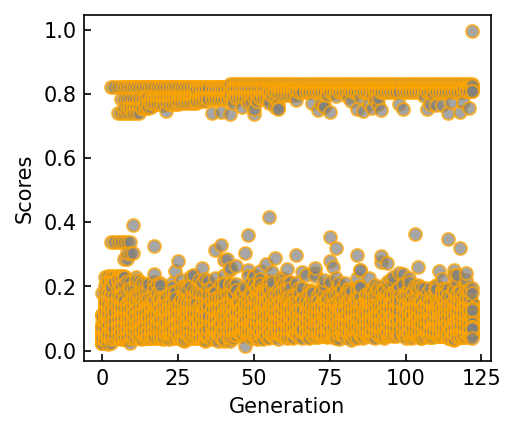

In [17]:
# Similar to Fig 3b---- Scores vs generation--- different run example
from matplotlib import cm
from matplotlib.colors import Normalize

scores = np.loadtxt('L2S_out/Pulsed/Fig3/Data/scores_3b.dat')
gen_no = np.loadtxt('L2S_out/Pulsed/Fig3/Data/gen_3b.dat')

#print(scores.shape, gen_no.shape)

fig3b, ax2 = plt.subplots(figsize=(3.5, 3), dpi=150, facecolor='white')
cmap = cm.viridis_r

# Scatter plot with colormap based on rank
for i in range(gen_no.shape[0]):
    ranks = np.argsort(np.argsort(scores[i, :]))
    norm = Normalize(vmin=ranks.min(), vmax=ranks.max())
    colors_score = cmap(norm(ranks))

    ax2.scatter([gen_no[i]] * n_pop, scores[i], alpha=0.7, edgecolor='orange', color='grey', s=38)
    
ax2.set_xlabel('Generation')
ax2.set_ylabel('Scores')
ax2.tick_params(direction='in')

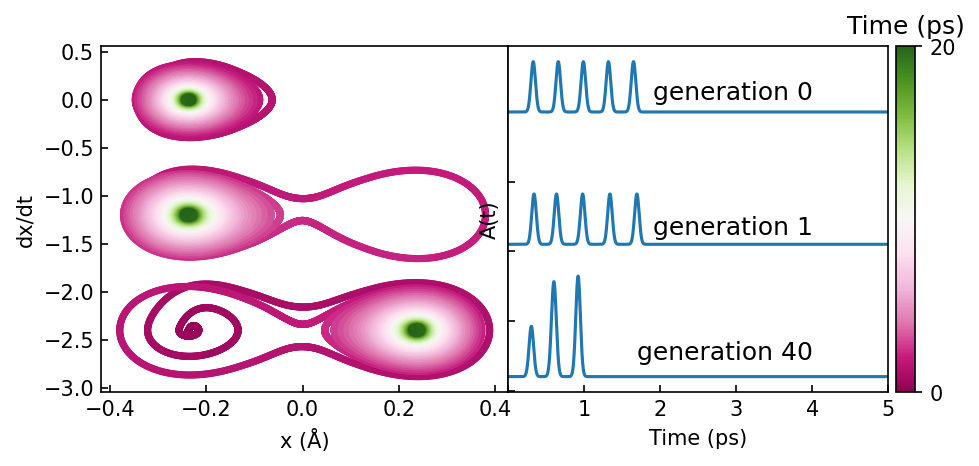

In [108]:
# Fig 3cd---- Phase space + Protocols
from mpl_toolkits.axes_grid1 import make_axes_locatable

sol_x_all = np.loadtxt('L2S_out/Pulsed/Fig3/Data/sol_x_3c.dat')
sol_v_all = np.loadtxt('L2S_out/Pulsed/Fig3/Data/sol_v_3c.dat')
At_all = np.loadtxt('L2S_out/Pulsed/Fig3/Data/protocol_3d.dat')

norm2 = Normalize(vmin=np.min(tfine*t_in_ps), vmax=np.max(tfine*t_in_ps))

fig3cd, (ax3,ax4) = plt.subplots(1,2,figsize=(7, 3), dpi=150, facecolor='white')

for idx in range(len(sol_x_all)-1,-1,-1):
    sc=ax3.scatter(sol_x_all[idx], sol_v_all[idx]-1.2*idx, c = tfine*t_in_ps, cmap='PiYG', edgecolor='none', norm=norm2, s=12)
    ax4.plot(tfine*t_in_ps, At_all[idx]-0.95*idx, color='C0', label=f'gen {idx+1}')

ax3.set_xlabel('x (Å)')
ax3.set_ylabel('dx/dt')
ax3.tick_params(direction='in')

divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
cax.set_position([0.8, 0.2, 0.03, 0.6])
cbar = fig3cd.colorbar(sc, cax=cax,orientation='vertical')
cbar.ax.set_title('Time (ps)')
cbar.set_ticks([norm2.vmin, norm2.vmax])
cbar.ax.set_yticklabels(['0', '20'])

ax4.set_xlabel('Time (ps)')
ax4.set_ylabel('A(t)', labelpad=0.5)
ax4.set_xlim(0,5)
ax4.tick_params(direction='in')
ax4.text(0.80, 0.90, "generation 0", transform=ax4.transAxes,fontsize=12, va='top', ha='right')
ax4.text(0.80, 0.51, "generation 1", transform=ax4.transAxes,fontsize=12, va='top', ha='right')
ax4.text(0.80, 0.15, "generation 122", transform=ax4.transAxes,fontsize=12, va='top', ha='right')
ax4.set_yticklabels([])
xticks_positions = ax4.get_xticks()
xticks_labels = ax4.get_xticklabels()
xticks_labels = [''] + [label.get_text() for label in xticks_labels[1:]]
ax4.set_xticks(xticks_positions)
ax4.set_xticklabels(xticks_labels)

plt.subplots_adjust(wspace=0)